# Inference of Gene Regulatory Network using Kinetic Ising Model


In [1]:
from datetime import date

print("Last run date:", date.today())

Last run date: 2024-08-13


In [2]:
# Importing essential libraries for data manipulation, mathematical operations, and plotting
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from pathlib import Path
import os
from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.colors as colors

# Importing custom libraries specific to this analysis
import lib.NetAnalysis as na
import lib.funcs_ko as funcs_ko
from lib.ml_wrapper import asynch_reconstruction
import lib.figs_funcs as fig_func
import lib.funcs_general as funcs_general

# Setting up matplotlib for LaTeX-style text rendering
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

# Uncomment the following lines during development for automatic module reloading
%load_ext autoreload
%autoreload 2


# Information and Data Loading


In [3]:
# Define the base directory for code and data using pathlib for better path handling
base_dir = Path("/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference")
path = base_dir / "GRN_Inference_CODE"
path_data = base_dir / "DATA"


In [4]:
# genes of OUR dataset
genes_reference = np.loadtxt(path_data/"general_info/genes_order.csv", dtype="str") #selected genes

# time steps
time=["00h", "06h", "12h", "24h", "48h"]

# Classifying genes based on the Carbognin paper (2023)
naive = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative_early = ["Nr0b1", "Zic3", "Rbpj"]
formative_late = ["Utf1", "Etv4", "Tcf15", "Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]

# Identifying genes in the dataset that are not classified into the above categories
other = [x for x in genes_reference if x not in naive and x not in formative_early and x not in formative_late]


## Mini-Bulk Data + PST

In [5]:
df_lN_mb_pst = pd.read_csv(path_data / "GE_data/processed/imp_genes_LogNorm_PST_MB.csv", header=0, index_col=0, sep=",")
# check che df_lN_mb_pst.index == genes_reference
print(np.sum(df_lN_mb_pst.index == genes_reference)/len(genes_reference))

1.0


In [6]:
print(df_lN_mb_pst.shape)

(24, 9547)


## Binarized Data (Half-max)

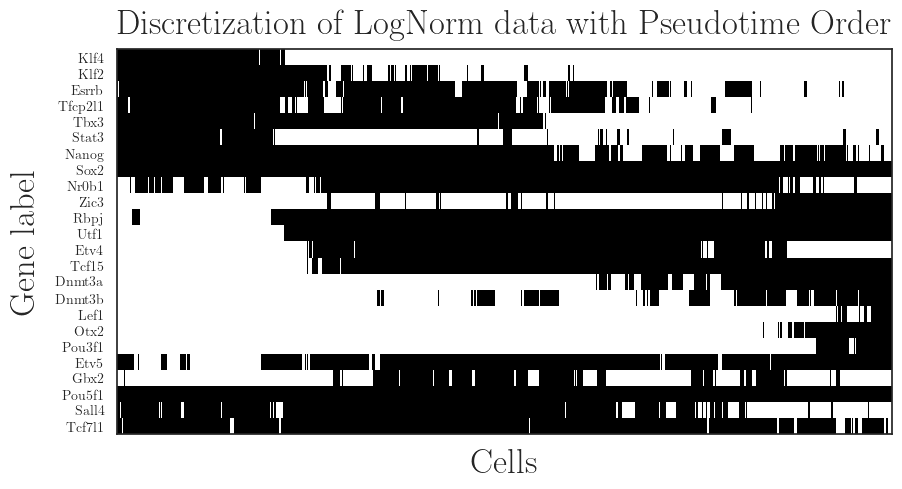

In [7]:
spins_df_lN_mb_pst = pd.read_csv(path_data /"GE_data/processed/imp_genes_LogNorm_PST_MB_Spins.csv", header=0, index_col=0, sep=",")
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig_func.raster_plot(np.array(spins_df_lN_mb_pst), ax,'Discretization of LogNorm data with Pseudotime Order', 1, genes_reference)
plt.show()



## Randomization

In [8]:
spins_df_lN_mb_pst_shuffle = np.load(path_data / "GE_data/processed/imp_genes_LogNorm_PST_MB_Spins_RND50Test.npy")
 
Ntest = spins_df_lN_mb_pst_shuffle.shape[0] 
print("Number of tests (shuffled datasets)):", Ntest)

Number of tests (shuffled datasets)): 50


In [9]:
check=True
if check:
    # Check the reshuffle
    print(funcs_general.check_shuffle(spins_df_lN_mb_pst_shuffle, Ntest))
    
    # zero expected if everithing is working fine

0.0


In [10]:
show = False
if show:
    for ii in range(0, Ntest, 60):
            fig_func.raster_plot(np.array(spins_df_lN_mb_pst_shuffle[ii,:,:]), 'Discretization of LogNorm data with PST - RND '+str(ii+1), 1, genes_reference[::-1])
            plt.show()    
            

## Known interactions

In [11]:
Known_Interactions_Exp = ["Stat3 Klf4 1", "Nanog Esrrb 1", "Stat3 Dnmt3b -1", 
                "Nanog Otx2 -1", "Nanog Pou3f1 -1",
                "Stat3 Gbx2 1", "Stat3 Tfcp2l1 1", 
                "Otx2 Pou3f1 1", "Otx2 Dnmt3a 1", 
                "Tcf7l1 Esrrb -1", "Tcf7l1 Klf2 -1", "Tcf7l1 Nanog -1", "Tcf7l1 Nr0b1 -1",  "Tcf7l1 Tfcp2l1 -1",  
                "Rbpj Nanog -1", "Rbpj Tbx3 -1", "Etv5 Lef1 1", "Etv5 Pou3f1 1"]


## KO Experiments Data 

### Leeb Data

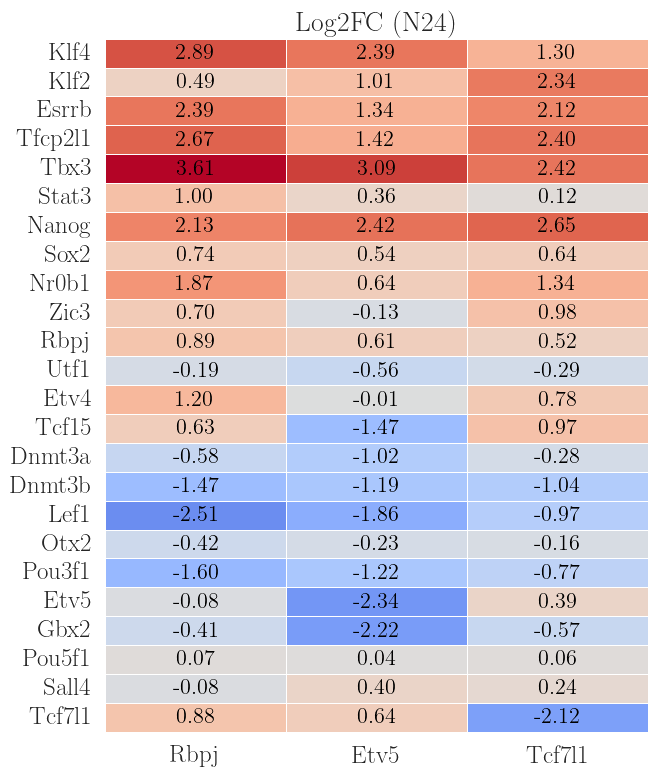

In [12]:
df_KO_N24_Leeb_uncl = pd.read_csv(path_data / 'Leeb_Data_Orig/df_KO_N24_uncleaned.csv', index_col=0, header=0)

plt.figure(figsize=(7,9))
# annotate using 3 decimal places
sns.heatmap(np.array(df_KO_N24_Leeb_uncl).astype(float), annot=True, fmt=".2f", 
            xticklabels=df_KO_N24_Leeb_uncl.columns, yticklabels=df_KO_N24_Leeb_uncl.index, 
           cmap="coolwarm", cbar=False, center=0, linewidth=.5, annot_kws={"size":16, 'color':'black'})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Log2FC (N24)", fontsize=20)
plt.show()


### Kalkan data

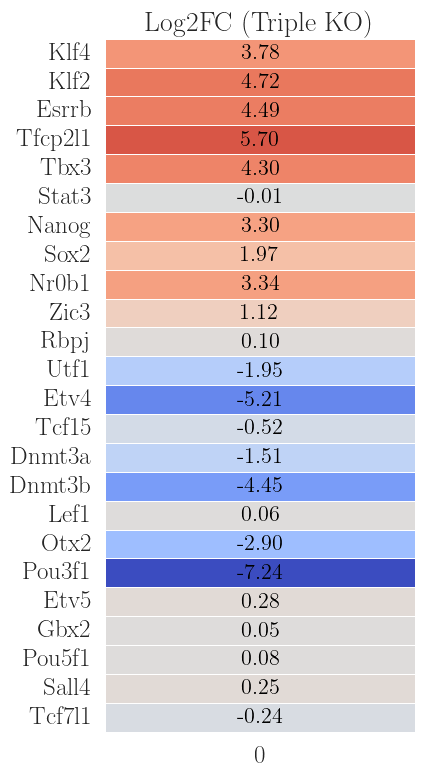

In [13]:
df_tKO_Kalkan = pd.read_csv(path_data / 'Kalkan_Data/df_tripleKO_diff.csv', index_col=0, header=0)

plt.figure(figsize=(4,9))
sns.heatmap(np.array(df_tKO_Kalkan).astype(float), annot=True, fmt=".2f", 
            xticklabels=df_tKO_Kalkan.columns, yticklabels=df_tKO_Kalkan.index, 
           cmap="coolwarm", cbar=False, center=0, linewidth=.5, annot_kws={"size":16, 'color':'black'})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Log2FC (Triple KO)", fontsize=20)
plt.show()

## Hyperparameter values

In [14]:
params = {"LAMBDA" : [0.01, 0.02, 0.03,0.04, 0.05, 0.07, 0.09],
          "lr"     : [0.8, 0.7, 0.6, 0.5, 0.4, 0.3],
          "drop"   : [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99],
          "edrop"  : [15, 20, 25, 30, 35],
          "opt"    : ['MOMENTUM','NADAM'],
          "MOM"    : [0.75, 0.8, 0.85, 0.9, 0.95, 0.99],
          "reg"    : ['L1'],
          "Nepochs": [500, 700, 800, 900, 1200]}


# Results


## Cluster Input data

In [16]:
# Perform linkage on your numpy array
Z_original = scipy.cluster.hierarchy.linkage(spins_df_lN_mb_pst.T, method='ward')

sns.set(font='Avenir')
sns.set(style="white")


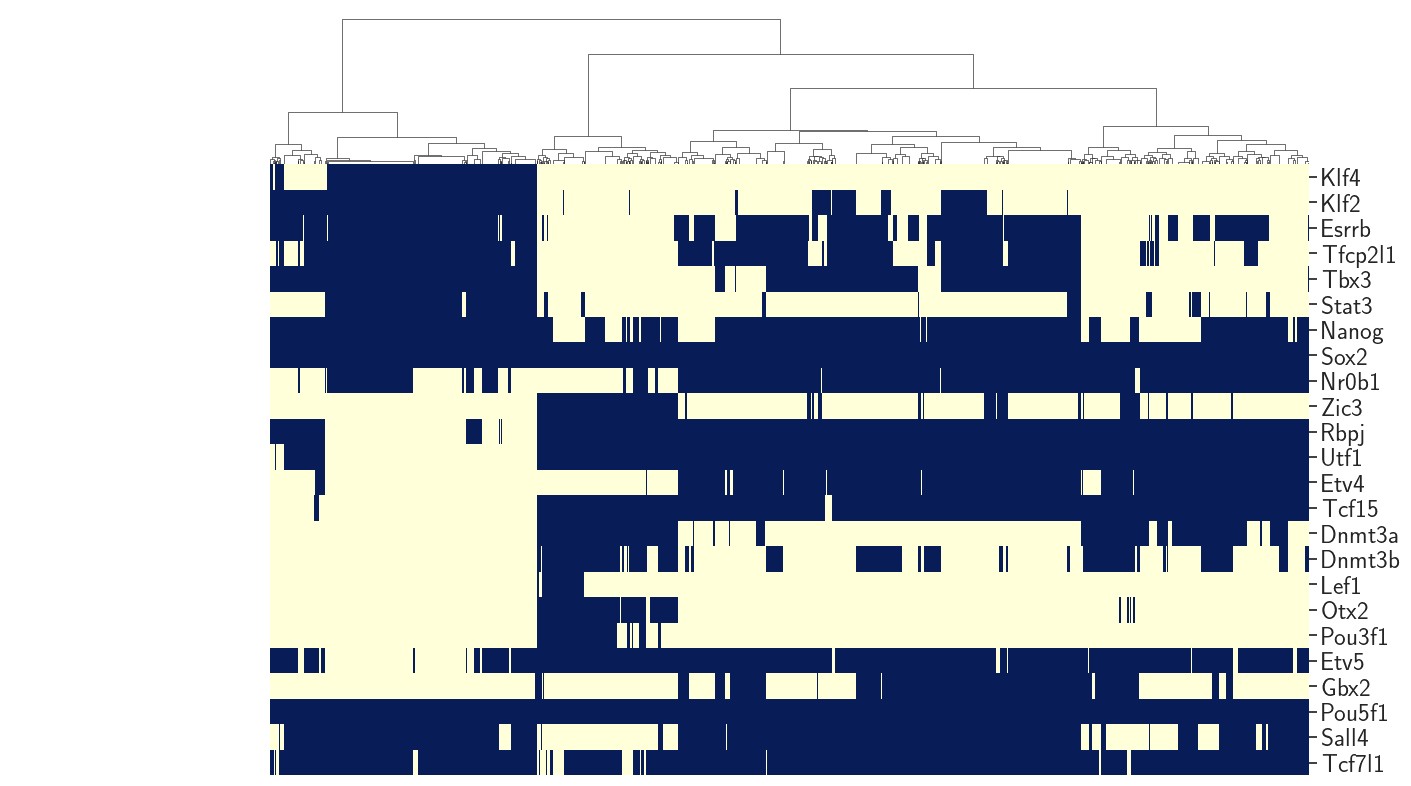

In [17]:
output_path = '/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/FIG/original_binarized_data_clustering.tiff'

# Creating clustermap
g = sns.clustermap(spins_df_lN_mb_pst, col_linkage=Z_original, cmap='YlGnBu',
                   yticklabels=genes_reference, 
                   cbar=False, figsize=(14,8), row_cluster=False, xticklabels=False)

for ax in g.ax_heatmap.get_yticklabels():
    ax.set_fontname('Avenir')
    ax.set_fontsize(18) 

plt.xticks([])
plt.yticks([])

g.savefig(output_path)

plt.show()


In [18]:
Z_original.shape
# find the number of cells in each cluster in which we are interested
n_cells = Z_original.shape[0]+1
print("Number of total cells", n_cells)

n_cells_cluster_big = Z_original[-2,3]
print(f"Number of cells in the biggest cluster: {n_cells_cluster_big} ({n_cells_cluster_big/n_cells:.2f})")
n_cells_cluster_small = n_cells-n_cells_cluster_big
print(f"Number of cells in the smallest cluster: {n_cells_cluster_small} ({n_cells_cluster_small/n_cells:.2f})")

Number of total cells 9547
Number of cells in the biggest cluster: 7098.0 (0.74)
Number of cells in the smallest cluster: 2449.0 (0.26)


In [19]:
# # This number can be adjusted based on your knowledge of the dataset
# k = 2  # Example number of clusters
# cluster_labels = fcluster(Z_original, k, criterion='maxclust')

# # Count the number of points in each cluster
# unique, counts = np.unique(cluster_labels, return_counts=True)
# cluster_size_dict = dict(zip(unique, counts))

# # Print the size of each cluster
# print(cluster_size_dict)

# # Identify indices of samples belonging to cluster 2
# indices_cluster_2 = np.where(cluster_labels == 1)[0]

# # Extract these samples from the original dataset
# naive_cells_dataset = spins_df_lN_mb_pst.iloc[:, indices_cluster_2]

# naive_cells_dataset.shape

# IGNITE RESULTS

In [20]:
## Loading Data for the model selection using the Fraction of correctly inferred interactions
Ntrials = 250
today = "noprior_2024_01_16"  #"noprior_2024_01_16" or other data
data_type = "pst_mb"
# LOADING data   
IGNITE_path = os.path.join(path_data, 'OUT_ISING', 'LogNORM', 'lN_arrays_' + data_type + '_' + str(today) + '.npz')
lN_arrays_sel = np.load(IGNITE_path)

lN_matx_sel = lN_arrays_sel['array_1']
lN_prec_sel = lN_arrays_sel['array_2']
# lN_int_val_sel = lN_arrays_sel['array_3']
lN_dist_sel = lN_arrays_sel['array_4']

if lN_prec_sel.shape[0] != Ntrials:
    print("ERROR: the number of trials is not correct")

### FCI vs CMD

In [21]:
print("Spearman corr coeff: ", scipy.stats.spearmanr(lN_prec_sel, lN_dist_sel, nan_policy='omit'))
plot_scatter = False
if plot_scatter:
    plt.figure(figsize=(8,6))
    fig_func.scatter_modelSelection(lN_prec_sel[:150], lN_dist_sel[:150])
    plt.show()

Spearman corr coeff:  SignificanceResult(statistic=-0.6929952185342494, pvalue=5.818822616636155e-36)


# Models selected by FCI or CMD

In [22]:
# select models with highest lN_prec_sel_true, fraction of known interactions correctly inferred
print("FCI part")
Nmodel_FCI = 10
interaction_thr = 0 # we consider all interactions, even with low values
idxs_sel_FCI = np.argsort(lN_prec_sel)[::-1][:Nmodel_FCI]

for ii in idxs_sel_FCI:
    print ("selected indices for FCI:", ii,
           f"CIf value, {lN_prec_sel[ii]:.3f}",
           f"Distance value, {lN_dist_sel[ii]:.3f}")


print("CMD part")
# select models with lowest lN_dist, distance between Orig and Exp Pearson matrices
Nmodel_CMD = 10
interaction_thr = 0 # we consider all interactions, even with low values
idxs_sel_CMD = np.argsort(lN_dist_sel)[:Nmodel_CMD]

for jj in idxs_sel_CMD:
    print ("selected indices for CMD:", jj,
           f"CIf value, {lN_prec_sel[jj]:.3f}",
           f"Distance value, {lN_dist_sel[jj]:.3f}")



FCI part
selected indices for FCI: 117 CIf value, 0.778 Distance value, 0.534
selected indices for FCI: 154 CIf value, 0.778 Distance value, 0.614
selected indices for FCI: 229 CIf value, 0.778 Distance value, 0.630
selected indices for FCI: 56 CIf value, 0.778 Distance value, 0.710
selected indices for FCI: 208 CIf value, 0.778 Distance value, 0.545
selected indices for FCI: 77 CIf value, 0.778 Distance value, 0.712
selected indices for FCI: 33 CIf value, 0.778 Distance value, 0.519
selected indices for FCI: 92 CIf value, 0.778 Distance value, 0.560
selected indices for FCI: 167 CIf value, 0.778 Distance value, 0.655
selected indices for FCI: 119 CIf value, 0.778 Distance value, 0.560
CMD part
selected indices for CMD: 194 CIf value, 0.667 Distance value, 0.428
selected indices for CMD: 242 CIf value, 0.722 Distance value, 0.432
selected indices for CMD: 38 CIf value, 0.722 Distance value, 0.441
selected indices for CMD: 136 CIf value, 0.722 Distance value, 0.447
selected indices for 

# Results' Analysis and figures

In [23]:
figs_path = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/FIG"


Selected model index: 194
CMD value:  0.4279173908623226
FCI value:  0.6666666666666666


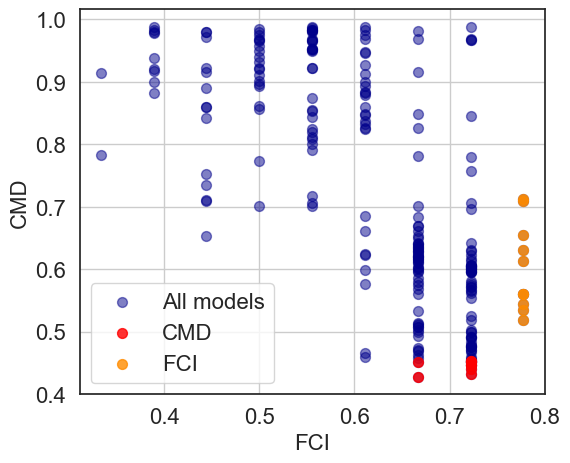

In [24]:
# Decide which model selection we want to analyse
idxs_sel = idxs_sel_CMD.copy()
# idxs_sel = idxs_sel_FCI.copy()

model_idx_sel = idxs_sel[0]
print("Selected model index:", model_idx_sel)
Nmodel_sel = len(idxs_sel)

# Visualise the selected model
visualise =  True
if visualise:
    print("CMD value: ", lN_dist_sel[model_idx_sel])
    print("FCI value: ", lN_prec_sel[model_idx_sel])
    plt.rcParams['text.usetex'] = False
    plt.figure(figsize=(6,5))
    # fig_func.scatter_modelSelection(lN_prec_sel, lN_dist_sel, label="All models")
    plt.scatter(lN_prec_sel, lN_dist_sel, color='darkblue', s=50, alpha=0.5, label="All models")
    plt.scatter(lN_prec_sel[idxs_sel_CMD], lN_dist_sel[idxs_sel_CMD], color='red', s=50, alpha=0.8, label="CMD")
    plt.scatter(lN_prec_sel[idxs_sel_FCI], lN_dist_sel[idxs_sel_FCI], color='darkorange', s=50, alpha=0.8, label="FCI")

    plt.xlabel("FCI", fontsize=16)
    plt.ylabel("CMD", fontsize=16)
    plt.grid()
    # x and y ticks font size
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    plt.legend(fontsize=16)
    plt.savefig(os.path.join(figs_path, 'FCI_CMD_scatter_IGNITE_10models.svg'), format='svg', transparent=True)
    plt.show()

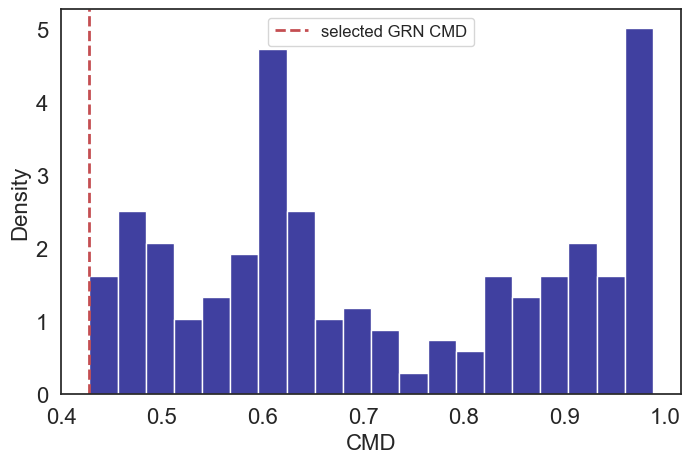

In [25]:
# plot the distribution of lN_dist_sel
plt.figure(figsize=(8,5))
sns.histplot(lN_dist_sel,bins=20, color='navy', stat='density')
# plot vertical line at lN_dist_sel[model_idx_sel]
plt.axvline(lN_dist_sel[model_idx_sel], color='r', linestyle='--', linewidth=2, label="selected GRN CMD")
plt.legend(fontsize=12, loc='upper center')
plt.xlabel("CMD", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig(os.path.join(figs_path,  'lN_dist_sel_dist.svg'))

## Inferred GRN

max abs value of the matrix: 1.7917743134799224
max abs value of the matrix: 0.6485681020601669


/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/figs_funcs.py:189: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbarM.ax.set_yticklabels(cbarM.ax.get_yticklabels(), fontname='Avenir')


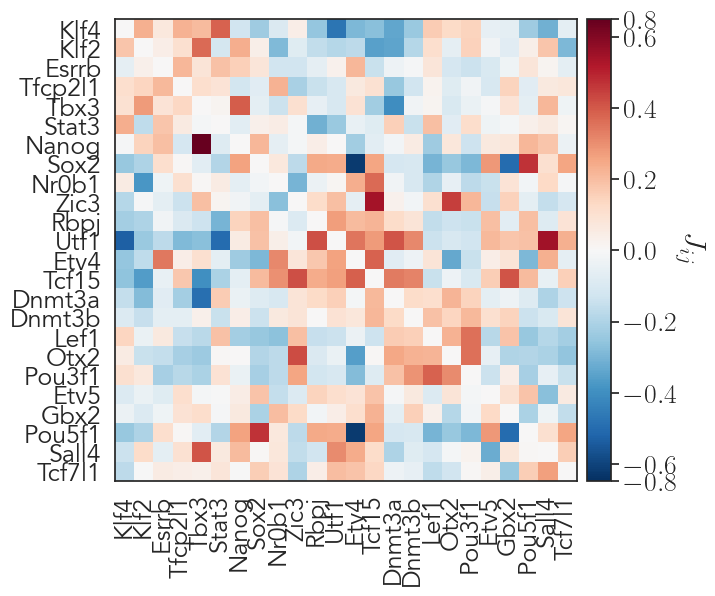

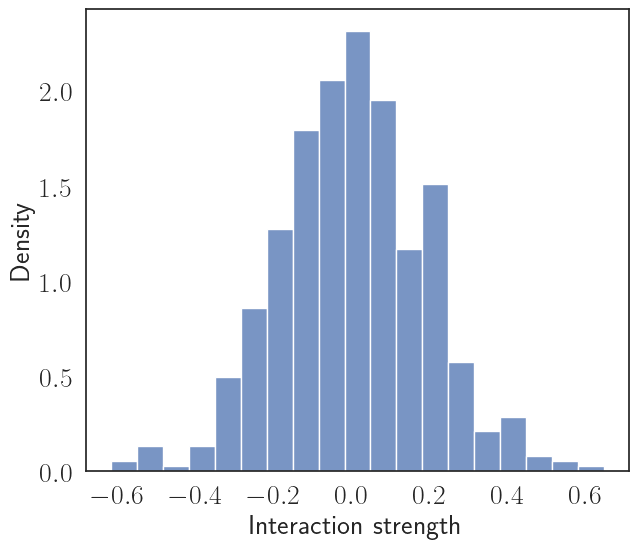

In [26]:
best_model_sel = np.squeeze(lN_matx_sel[model_idx_sel,:,:])

# fig, ax = plt.subplots(1, 1, figsize=(8,7))
# fig_func.plotmat(best_model_sel, fig, ax, genes_reference, "", fix=False)
# plt.show()

best_model_nodiag = best_model_sel.copy()
print("max abs value of the matrix:", np.max(np.abs(best_model_nodiag)))
np.fill_diagonal(best_model_nodiag, 0)
print("max abs value of the matrix:", np.max(np.abs(best_model_nodiag)))


fig, ax = plt.subplots(1, 1, figsize=(7,6))
fig_func.plotmat(best_model_nodiag, fig, ax, genes_reference, "", fix=False)

adjacency_matrix_path = os.path.join(figs_path, "GRN_IGNITE_LN_pst_mb.svg")
plt.savefig(adjacency_matrix_path, format='svg', transparent=True)
plt.show()
plt.close(fig) 

plt.figure(figsize=(7,6))
bins = np.linspace(np.ndarray.flatten(best_model_nodiag).min(), np.ndarray.flatten(best_model_nodiag).max(), 20)
sns.histplot(np.ndarray.flatten(best_model_nodiag), stat="density", bins=bins)
plt.ylabel("Density", fontsize=20)
plt.xlabel("Interaction strength", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

distribution_path = os.path.join(figs_path, "GRN_IGNITE_LN_pst_mb_distribution.svg")
plt.savefig(distribution_path, format='svg', transparent=True)
plt.show()
plt.close()  




Total edges drawn: 18


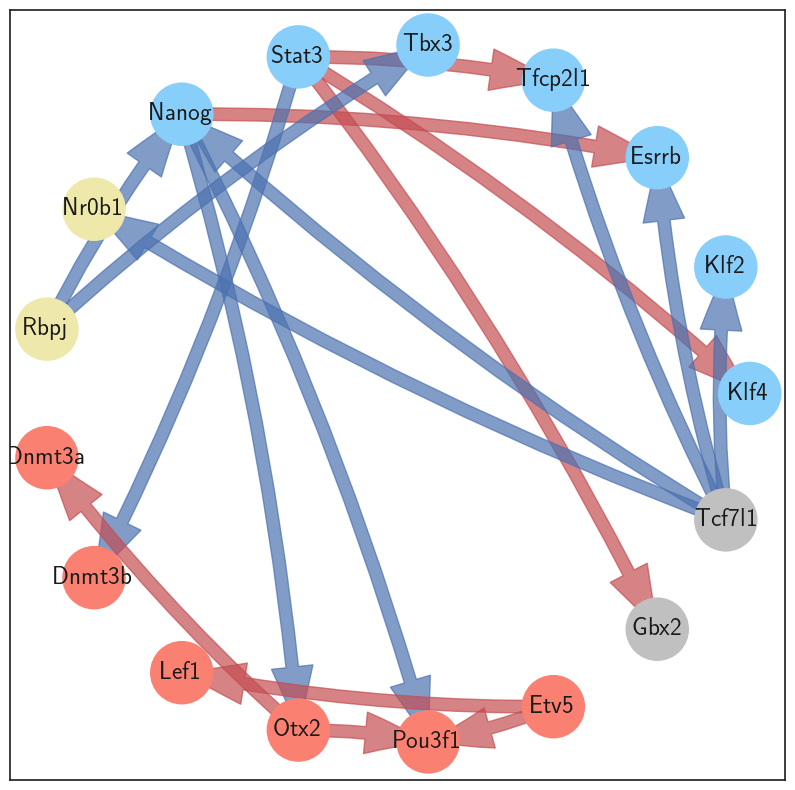

Total edges drawn: 12


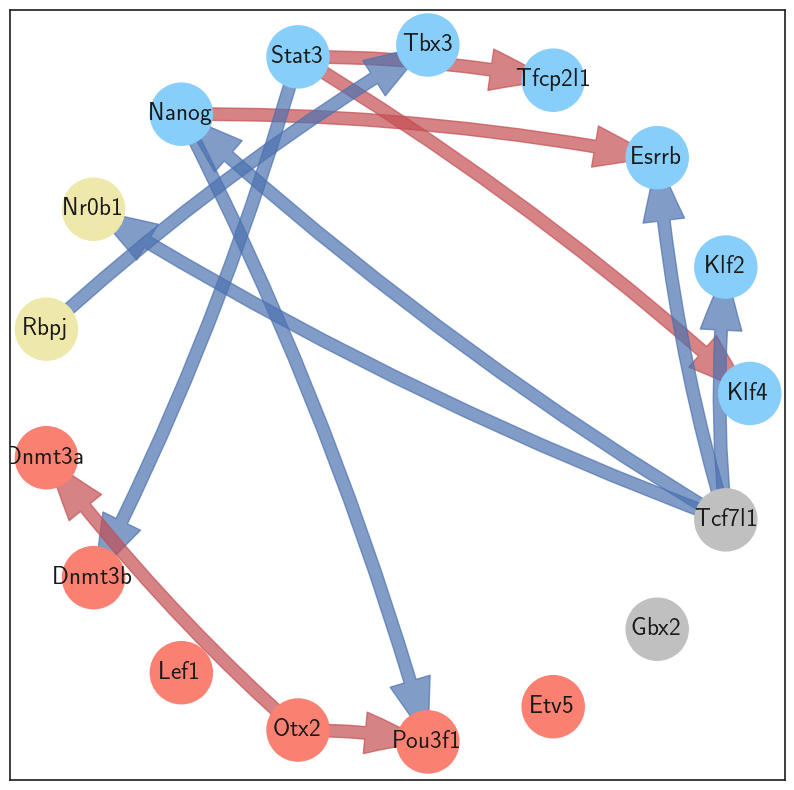

In [27]:
adj_matx = na.to_adj_matrix(best_model_sel, thr = 0.0)
# visualize the adjacency matrix
visualise_adj = False
if visualise_adj:
    plt.figure(figsize=(7,6))
    sns.heatmap(adj_matx, cmap="coolwarm", cbar=False, center=0, linewidth=.5)
    plt.xticks(fontsize=16, rotation=90, labels=genes_reference, ticks=np.arange(0.5, len(genes_reference), 1))
    plt.yticks(fontsize=16, rotation=0, labels=genes_reference[::-1], ticks=np.arange(0.5, len(genes_reference), 1))


na.visualize_graphTrue(adj_matx, genes_reference, naive, formative_early, formative_late, Known_Interactions_Exp,"")
KInet_true_path = os.path.join(figs_path, "GRN_TRUE_KInet.svg")
plt.savefig(KInet_true_path, format='svg')
plt.show()
plt.close()

na.visualize_graphSel(adj_matx, genes_reference, naive, formative_early, formative_late, Known_Interactions_Exp,"")
KInet_path = os.path.join(figs_path, "GRN_IGNITE_LN_pst_mb_KInet.svg")
plt.savefig(KInet_path, format='svg')
plt.show()
plt.close()


## Model Analysis

In [28]:
N_genes = spins_df_lN_mb_pst.shape[0]
N_ts = spins_df_lN_mb_pst.shape[1] 
N_sim = spins_df_lN_mb_pst_shuffle.shape[0] 

# to compute the distance between matrices we need the correlation matrices of shuffled data
cm_original_lN = np.corrcoef(spins_df_lN_mb_pst)
corr_matxs_rnd_lN = np.array([np.corrcoef(spins_df_lN_mb_pst_shuffle[i,:,:]) for i in range(spins_df_lN_mb_pst_shuffle.shape[0])])
# distance for shuffled data
noise_dist = np.mean([funcs_ko.sum_squared_abs_diff(cm_original_lN, corr_matxs_rnd_lN[i,:,:]) for i in range(spins_df_lN_mb_pst_shuffle.shape[0])])


/Users/cleliacorridori/anaconda3/envs/ignite_env/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/cleliacorridori/anaconda3/envs/ignite_env/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### Correlation Matrices Comparison (sperimental vs generated data)

Model Selection: Trial  194

Params for LogNorm (0)
 {'LAMBDA': 0.09, 'lr': 0.8, 'drop': 0.65, 'edrop': 20, 'opt': 'NADAM', 'MOM': 0.75, 'reg': 'L1', 'Nepochs': 1200}
Fraction of correctly inferred interactions: 0.67, distance: 0.43


/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/fun_asynch.py:220: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  return 1/delta_t*(np.dot(spins[:,1:], spins[:,:-1].T)/Nsteps - cov)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Epoch 	 Max J gradient 	 Max h gradient 	 Max change in J 	 Max change in h 	 Likelihood


/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/fun_asynch.py:402: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  gJ = nb_dJ(cov, dot_cov, spins, new_h, new_J, theta)


300 	 0.017013 	 0.003393 	 0.0001 	 0.0 	 -2.8742
600 	 0.016694 	 0.00334 	 0.0 	 0.0 	 -2.8799
900 	 0.016693 	 0.003339 	 0.0 	 0.0 	 -2.88
1200 	 0.016693 	 0.003339 	 0.0 	 0.0 	 -2.88
early stopping implemented at epoch:  1200


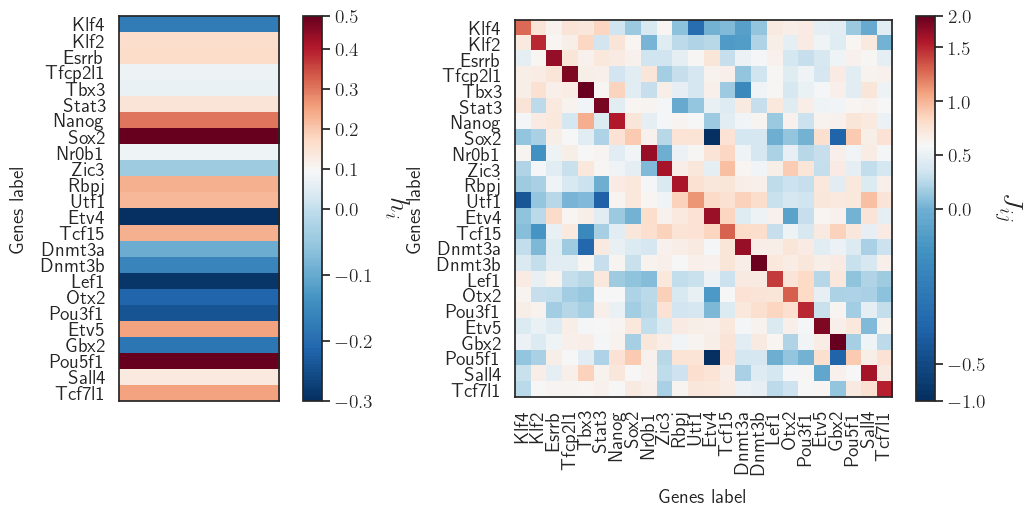

/Users/cleliacorridori/anaconda3/envs/ignite_env/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/cleliacorridori/anaconda3/envs/ignite_env/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [29]:
N_genes = genes_reference.shape[0]
N_ts = spins_df_lN_mb_pst_shuffle.shape[2]
np.random.seed(20961)  
for ii in range(Ntrials):
    par_sel = {}
    for jj in params.keys():
        par_sel[jj] = np.random.choice(params[jj])
        
    if ii == model_idx_sel:
        print("Model Selection: Trial ", ii)
        print("\nParams for LogNorm (0)\n", par_sel)
        print("Fraction of correctly inferred interactions: {:.2f}, distance: {:.2f}".format(lN_prec_sel[ii], lN_dist_sel[ii]))
        
        # The selected model computation
        models_selected = asynch_reconstruction(np.array(spins_df_lN_mb_pst), delta_t = 1, LAMBDA = par_sel["LAMBDA"], opt = par_sel['opt'], MOM=par_sel["MOM"], reg = 'L1', ax_names=genes_reference) #opt = 'MOMENTUM', MOM=0.99
        models_selected.reconstruct(np.array(spins_df_lN_mb_pst), Nepochs = par_sel["Nepochs"], start_lr = par_sel["lr"], drop = par_sel["drop"], edrop = par_sel["edrop"])

        # evaluate the model with the comparison between original and simulated Pearson correlation matrix:
        spins_new_lN = np.zeros((N_genes, N_ts, 250))
        cm_sim_lN = np.zeros((spins_new_lN.shape[0], spins_new_lN.shape[0], spins_new_lN.shape[2]))
        for ll in range(250):
            # GENERATING DATA: generate N_sim new time series of spins using model
            spins_new_lN[:,:,ll] = models_selected.generate_samples(seed=ll*2, t_size=N_ts)
            cm_sim_lN[:,:, ll] = np.corrcoef(spins_new_lN[:,:,ll])
        break


#### t-test for d_IGNITE

In [30]:
# shuffle the data
n_shuffling = 250 # was 500 for the paper # number of shuffling
N_rows = spins_df_lN_mb_pst.shape[0]
N_cols = spins_df_lN_mb_pst.shape[1]

# Linearize
val_rnd = np.reshape(np.array(spins_df_lN_mb_pst), (N_cols*N_rows))
# reshuflle for Ntest times
spins_df_lN_mb_pst_shuffle = np.zeros((n_shuffling, N_rows, N_cols))
for ii in range(n_shuffling):
    np.random.seed(1234+ii)
    # Random reshuffle of the binnarized GE data
    np.random.shuffle(val_rnd)
    val_rnd_matx = val_rnd.reshape(N_rows,N_cols) # Reshape to the original shape
    trial_long = pd.DataFrame(val_rnd_matx)
    # Save the shuffled DataFrame
    spins_df_lN_mb_pst_shuffle[ii,:,:] = trial_long
    
N_genes = spins_df_lN_mb_pst.shape[0]
N_ts = spins_df_lN_mb_pst.shape[1] 
N_sim = spins_df_lN_mb_pst_shuffle.shape[0] 

# to compute the distance between matrices we need the correlation matrices of shuffled data
cm_original_lN = np.corrcoef(spins_df_lN_mb_pst)
corr_matxs_rnd_lN = np.array([np.corrcoef(spins_df_lN_mb_pst_shuffle[i,:,:]) for i in range(spins_df_lN_mb_pst_shuffle.shape[0])])


In [31]:
dist = np.array([funcs_ko.sum_squared_abs_diff(cm_original_lN, cm_sim_lN[:,:,i]) for i in range(cm_sim_lN.shape[2])])

rnd_dists = np.array([funcs_ko.sum_squared_abs_diff(cm_original_lN, corr_matxs_rnd_lN[i,:,:]) for i in range(spins_df_lN_mb_pst_shuffle.shape[0])])

# t-test
t_stat, p_value = stats.ttest_ind(dist, rnd_dists)

print("Statistiche t:", t_stat)
print("P-value:", p_value)

Statistiche t: -43.4936300183489
P-value: 1.0148835271878856e-171


#### normalized distance

In [32]:
# distance for shuffled data
noise_dist = np.nanmean([funcs_ko.sum_squared_abs_diff(cm_original_lN, corr_matxs_rnd_lN[i,:,:]) for i in range(spins_df_lN_mb_pst_shuffle.shape[0])])

dist = np.mean([funcs_ko.sum_squared_abs_diff(cm_original_lN, cm_sim_lN[:,:,i]) for i in range(cm_sim_lN.shape[2])])/ noise_dist # normalize by the noise
dist_std = np.std([funcs_ko.sum_squared_abs_diff(cm_original_lN, cm_sim_lN[:,:,i]) for i in range(cm_sim_lN.shape[2])])/ noise_dist # normalize by the noise
if  np.isnan(cm_sim_lN).sum() > (spins_new_lN.shape[0]*spins_new_lN.shape[0]*spins_new_lN.shape[2])-spins_new_lN.shape[0]*spins_new_lN.shape[0]*0.5*spins_new_lN.shape[2]:
    dist =np.nan
print("Distanza: {:.3f} e media std: {:.2f}".format(dist, dist+2*dist_std))

Distanza: 0.428 e media std: 0.84


/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/figs_funcs.py:189: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbarM.ax.set_yticklabels(cbarM.ax.get_yticklabels(), fontname='Avenir')


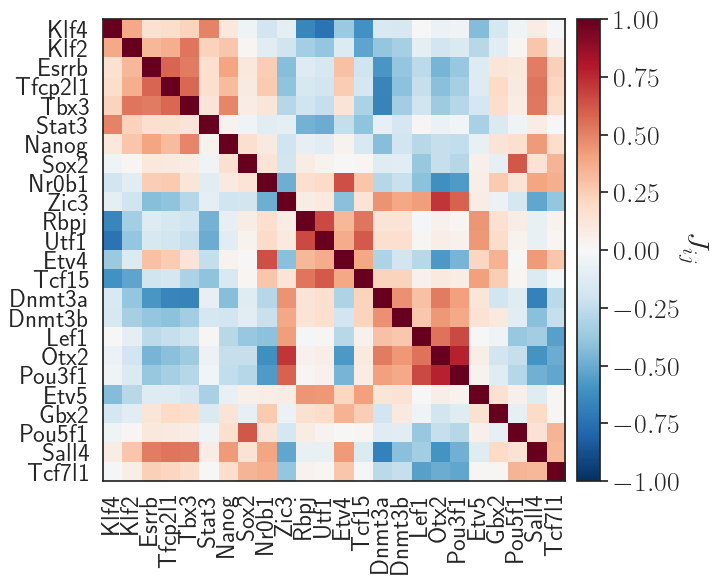

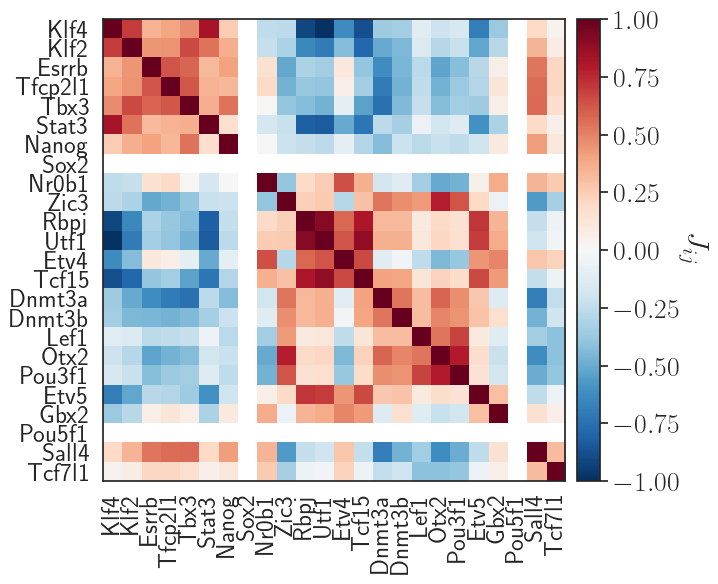

In [33]:
fig_folder_path = '/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/FIG'

# Visualize the simulated correlation matrices
cm_sim_lN_mean = np.nanmean(cm_sim_lN, axis=2)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig_func.plotmat(cm_sim_lN_mean, fig, ax, genes_reference, "", fix = True)
fig.savefig(os.path.join(fig_folder_path, 'cm_IGNITE_generated_mean.svg'), format='svg', bbox_inches='tight')
plt.show()

# Visualize the Original correlation matrices
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig_func.plotmat(cm_original_lN, fig, ax, genes_reference, "", fix = True)
fig.savefig(os.path.join(fig_folder_path, 'cm_IGNITE_INPUT_ga.svg'), format='svg', bbox_inches='tight')

plt.show()

    

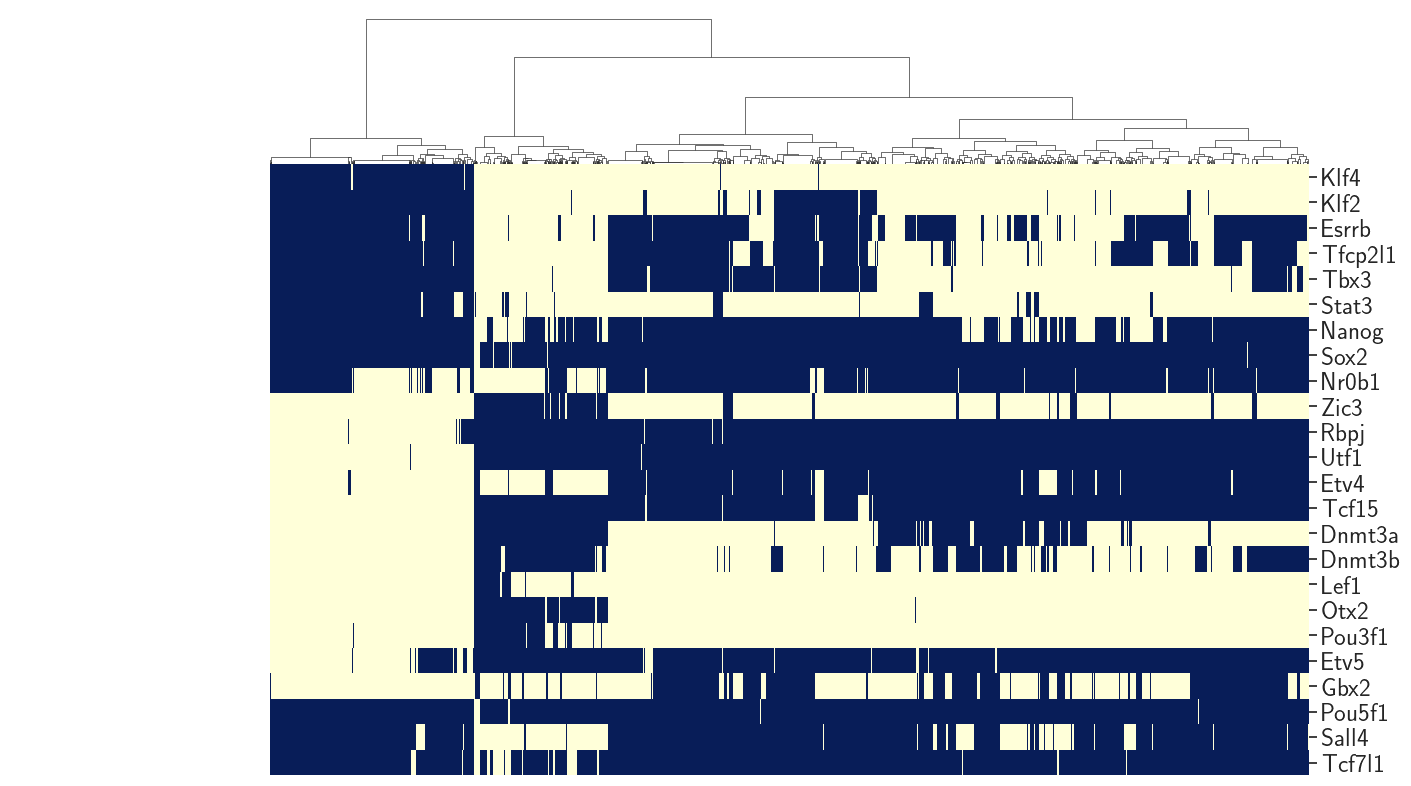

Number of naive cells: 7674.0, fraction: 0.80
Number of mixed cells: 1873.0, fraction: 0.20


In [34]:
# Clustering
jj=6 # select one of the simulated datasets
# for jj in range(10):
Z = scipy.cluster.hierarchy.linkage(spins_new_lN[:,:,jj].T, method='ward') # Note: we are showing just one simulated dataset, but you can do the same for all of them

output_path = '/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/FIG/generated_wt_binarized_data_clustering.tiff'

# Creating clustermap
g = sns.clustermap(spins_new_lN[:,:, jj], col_linkage=Z, cmap='YlGnBu',
                   yticklabels=genes_reference, 
                   cbar=False, figsize=(14,8), row_cluster=False, xticklabels=False)

for ax in g.ax_heatmap.get_yticklabels():
    ax.set_fontname('Avenir')
    ax.set_fontsize(18) 

plt.xticks([])
plt.yticks([])

g.savefig(output_path)

plt.show()

# find the number of cells in each cluster in which we are interested
n_cells = Z.shape[0]+1
# chech the number of naive cells
n_cells_cluster_naive = Z[-2,3]
print(f"Number of naive cells: {n_cells_cluster_naive}, fraction: {n_cells_cluster_naive/n_cells:.2f}")
n_cells_cluster_mixed = n_cells-n_cells_cluster_naive
print(f"Number of mixed cells: {n_cells_cluster_mixed}, fraction: {n_cells_cluster_mixed/n_cells:.2f}")


### KO

In [35]:
# number of generated dataset with KO implemented
N_test_KO = N_sim 
KO_goodness_sel = np.zeros(4)
dist  = np.zeros(Ntrials)
print("Model Selection: Trial ", model_idx_sel)

# Single KO
KO_gene_T_spins = ["Rbpj", "Etv5", "Tcf7l1"]

diff_lN_Rbpj, exp_logFC_Rbpj, KO_genes_reference_Rbpj = funcs_ko.KO_wrap(KO_gene_T_spins[0], 
                                                                    best_model_sel[:,:], 
                                                                    models_selected, genes_reference, 
                                                                    spins_new_lN[:,:,:N_test_KO], 
                                                                    df_KO_N24_Leeb_uncl,
                                                                    N_test_KO=N_test_KO) 

diff_lN_Etv5, exp_logFC_Etv5, KO_genes_reference_Etv5 = funcs_ko.KO_wrap(KO_gene_T_spins[1], 
                                                                    best_model_sel[:,:], 
                                                                    models_selected, genes_reference, 
                                                                    spins_new_lN[:,:,:N_test_KO], 
                                                                    df_KO_N24_Leeb_uncl, 
                                                                    N_test_KO=N_test_KO)

diff_lN_Tcf7l1, exp_logFC_Tcf7l1, KO_genes_reference_Tcf7l1 = funcs_ko.KO_wrap(KO_gene_T_spins[2], 
                                                                    best_model_sel[:,:], 
                                                                    models_selected, genes_reference, 
                                                                    spins_new_lN[:,:,:N_test_KO], 
                                                                    df_KO_N24_Leeb_uncl, 
                                                                    N_test_KO=N_test_KO)

# Triple KO
KO_lN_rec_matx_T_spins, KO_lN_rec_field_T_spins, KO_gene_idk_T, KO_genes_reference_T = funcs_ko.info_KO(best_model_sel, 
                                                                                                        models_selected, KO_gene_T_spins,
                                                                                                        genes_order=genes_reference, 
                                                                                                        multiple=True) # For triple KO
# remove row of the KO genes
wt_lN_mb_pst_spins_forKO_T = np.delete(spins_new_lN[:,:,:N_test_KO], KO_gene_idk_T, axis=0)#+1

# generate KO activity and compute the average KO and WT activity
KO_T_weighted_avg, KO_T_weighted_std, wt_T_avg, wt_T_std, KO_T_spins = funcs_ko.KO_avg_weighted(KO_lN_rec_matx_T_spins,
                                                                                                KO_lN_rec_field_T_spins, 
                                                                                                wt_lN_mb_pst_spins_forKO_T, 
                                                                                                N_test_KO=N_test_KO, N_time=N_ts)

# remove row of the KO from EXPERIMENTAL DATA
df_tKO_Kalkan_sel = df_tKO_Kalkan.drop(KO_gene_T_spins) #(["Etv5","Rbpj", "Tcf7l1"])
# search gene present in genes_reference and absent in df_tKO_Kalkan_sel and thei indices
common_genes = [x for x in KO_genes_reference_T if x in df_tKO_Kalkan_sel.index]
common_genes_idx = [x for x in range(len(KO_genes_reference_T)) if KO_genes_reference_T[x] in df_tKO_Kalkan_sel.index]
# select only simulated KO and WT for which we know experimental tKO
KO_T_weighted_avg_sel_T = KO_T_weighted_avg[common_genes_idx]
KO_T_weighted_std_sel_T = KO_T_weighted_std[common_genes_idx]
wt_T_avg_sel_T = wt_T_avg[common_genes_idx]
wt_T_std_sel_T = wt_T_std[common_genes_idx]

diff_sim_T = funcs_ko.KO_diff_sim(KO_T_weighted_avg_sel_T, KO_T_weighted_std_sel_T ,wt_T_avg_sel_T, wt_T_std_sel_T)

# Normalizing differences and log2FC
diff_sim   = np.array([diff_lN_Rbpj, diff_lN_Etv5, diff_lN_Tcf7l1])
log2FC_exp = np.array([exp_logFC_Rbpj, exp_logFC_Etv5, exp_logFC_Tcf7l1])
genes_KOs  = np.array([KO_genes_reference_Rbpj, KO_genes_reference_Etv5, KO_genes_reference_Tcf7l1])

diff_max = max(np.abs(diff_sim).max(), np.abs(diff_sim_T).max())
diff_sim_norm = diff_sim/diff_max
diff_sim_T_norm = diff_sim_T/diff_max

log2FC_exp_norm = log2FC_exp/np.abs(log2FC_exp).max()
df_tKO_Kalkan_norm = df_tKO_Kalkan_sel/np.abs(df_tKO_Kalkan_sel).max()

diff_thr = 0.05

# Rbpj
print(funcs_ko.fraction_agreement(diff_sim_norm[0,:], log2FC_exp_norm[0,:], genes_KOs[0,:], diff_thr))
KO_goodness_sel[0] = funcs_ko.fraction_agreement(diff_sim_norm[0,:], log2FC_exp_norm[0,:], genes_KOs[0,:], diff_thr)[3]
# Etv5
print(funcs_ko.fraction_agreement(diff_sim_norm[1,:], log2FC_exp_norm[1,:], genes_KOs[1,:], diff_thr))
KO_goodness_sel[1] = funcs_ko.fraction_agreement(diff_sim_norm[1,:], log2FC_exp_norm[1,:], genes_KOs[1,:], diff_thr)[3]
# Tcf7l1
print(funcs_ko.fraction_agreement(diff_sim_norm[2,:], log2FC_exp_norm[2,:], genes_KOs[2,:], diff_thr))
KO_goodness_sel[2] = funcs_ko.fraction_agreement(diff_sim_norm[2,:], log2FC_exp_norm[2,:], genes_KOs[2,:], diff_thr)[3]
# Triple
print(funcs_ko.fraction_agreement(diff_sim_T_norm, np.array(df_tKO_Kalkan_norm).squeeze(), np.array(common_genes), diff_thr))
KO_goodness_sel[3] = funcs_ko.fraction_agreement(diff_sim_T_norm, np.array(df_tKO_Kalkan_norm).squeeze(), np.array(common_genes), diff_thr)[3]



Model Selection: Trial  194
(0.30434782608695654, 0.30434782608695654, 0.043478260869565216, 0.6521739130434783)
(0.30434782608695654, 0.34782608695652173, 0.08695652173913043, 0.7391304347826086)
(0.08695652173913043, 0.17391304347826086, 0.043478260869565216, 0.30434782608695654)
(0.3333333333333333, 0.2857142857142857, 0.047619047619047616, 0.6666666666666667)


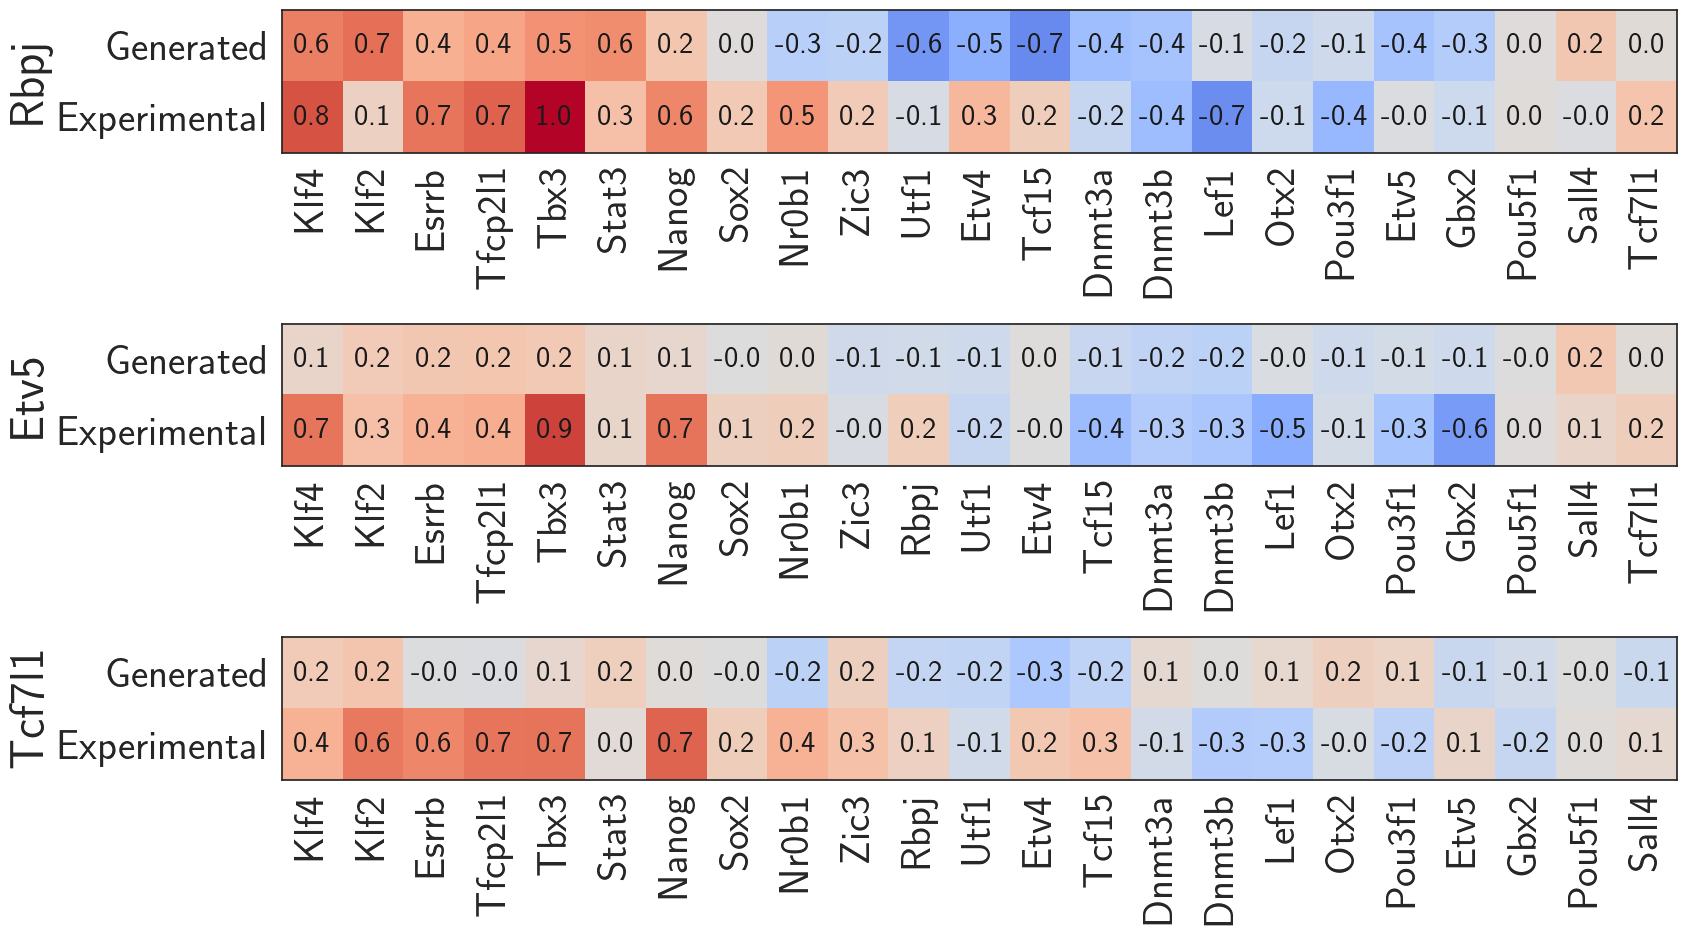

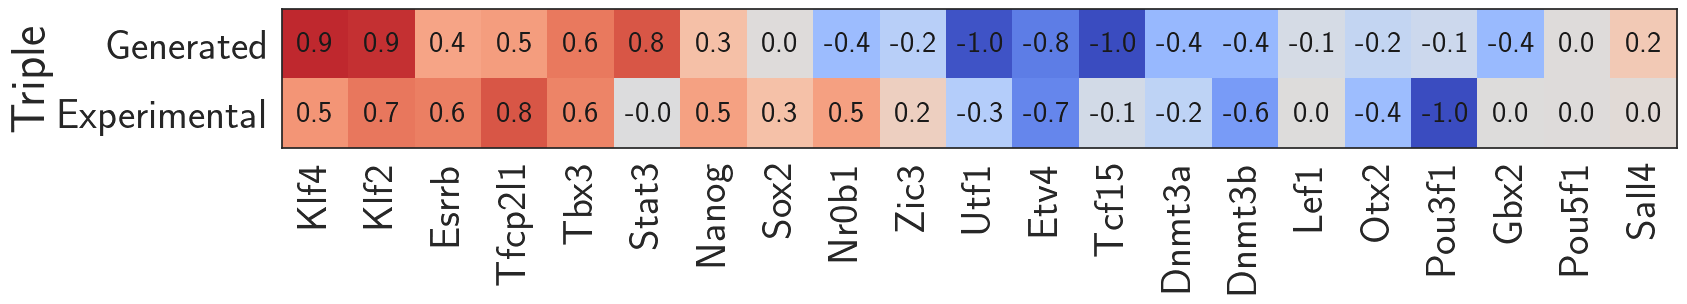

In [36]:
fig, ax = plt.subplots(3, 1, figsize=(18,10), gridspec_kw={'height_ratios': [1,1,1]})
funcs_ko.KO_heat_comparison_T(diff_sim_norm[0,:], log2FC_exp_norm[0,:], "Rbpj", genes_KOs[0,:], fig, ax[0], Norm=False)
funcs_ko.KO_heat_comparison_T(diff_sim_norm[1,:], log2FC_exp_norm[1,:], "Etv5", genes_KOs[1,:], fig, ax[1], Norm=False)
funcs_ko.KO_heat_comparison_T(diff_sim_norm[2,:], log2FC_exp_norm[2,:], "Tcf7l1", genes_KOs[2,:], fig, ax[2], Norm=False)
plt.subplots_adjust(hspace=1.2)
# save the figure as svg
fig.savefig(os.path.join(fig_folder_path, 'single_KO_heatmap_IGNITE.svg'), format='svg', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(18,1.8), gridspec_kw={'height_ratios': [1]})
funcs_ko.KO_heat_comparison_T(diff_sim_T_norm, np.array(df_tKO_Kalkan_norm).squeeze(), "Triple", np.array(common_genes),fig, ax,  Norm=False)
fig.savefig(os.path.join(fig_folder_path, 'triple_KO_heatmap_IGNITE.svg'), format='svg', bbox_inches='tight')

plt.show()


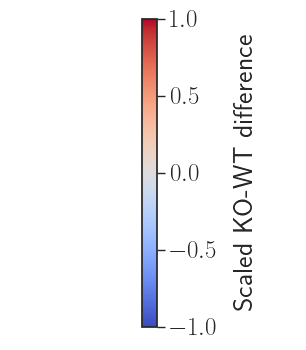

In [37]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.axis('off')
# Aggiunta della colorbar
im0 = ax.imshow(np.array([diff_sim_norm[0,:],log2FC_exp_norm[0,:]]), cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
im0.set_visible(False)
cbar = fig.colorbar(im0, ax=ax, orientation='vertical', pad=-1, aspect=20,shrink=1)
cbar.set_label("Scaled KO-WT difference", fontsize=20, labelpad=10)
cbar.ax.yaxis.set_tick_params(width=1)
# aumento font yticks
cbar.ax.yaxis.set_tick_params(labelsize=18)
cbar.ax.tick_params(axis='y', pad=3)

# save as svg
fig.savefig(os.path.join(fig_folder_path, 'colorbar_IGNITE_KO.svg'), format='svg', bbox_inches='tight')
plt.show()


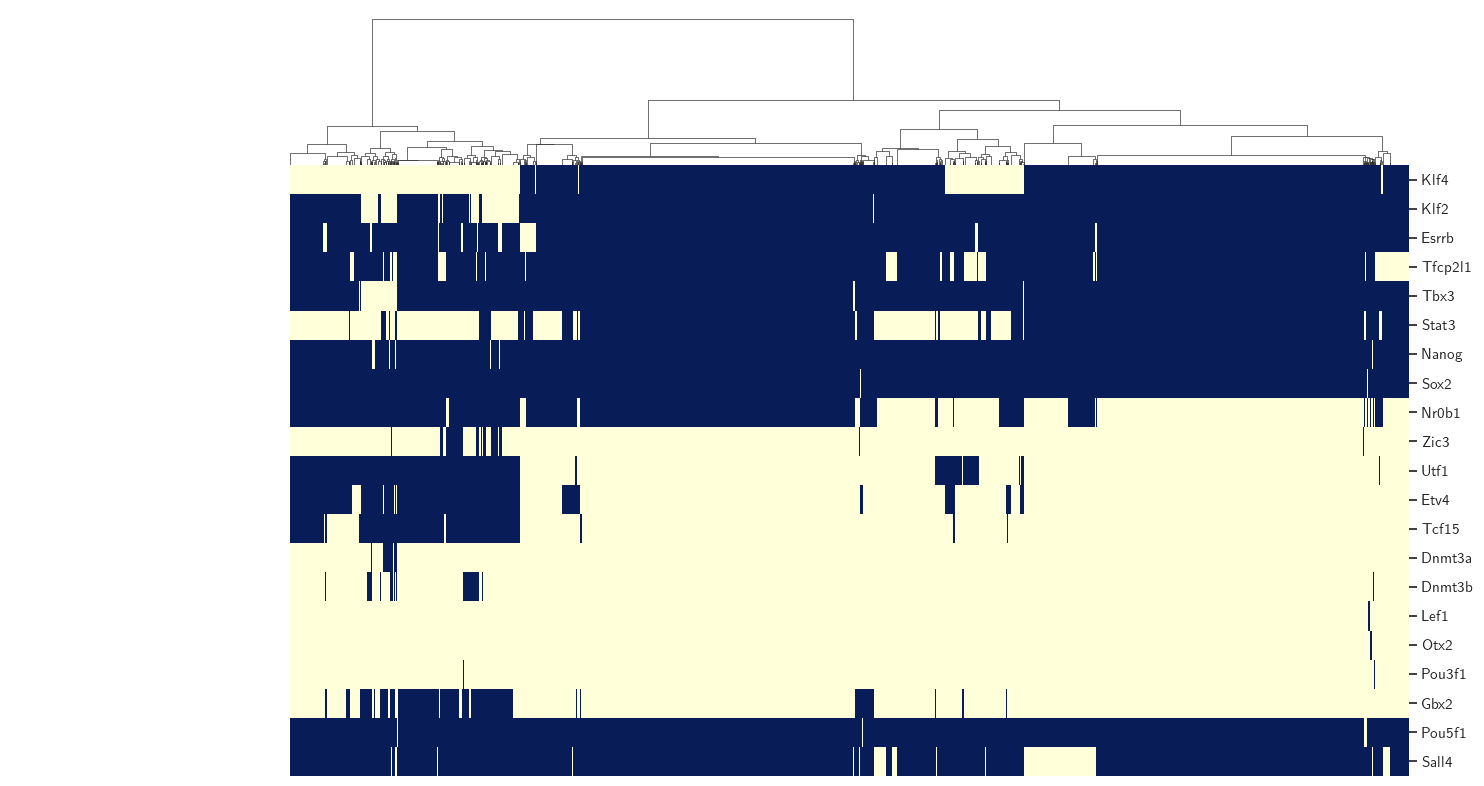

Number of naive cells: 7584.0, fraction: 0.79
Number of mixed cells: 1963.0, fraction: 0.21


In [38]:
jj=4
output_path = '/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/FIG/generated_Tko_binarized_data_clustering.tiff'

# Perform linkage on your numpy array
Z = scipy.cluster.hierarchy.linkage(KO_T_spins[:,:,jj].T, method='ward')
g_tKO = sns.clustermap(KO_T_spins[:,:,jj], col_linkage=Z, cmap='YlGnBu',
            yticklabels=KO_genes_reference_T, xticklabels=[],
            cbar=False, figsize=(15,8), row_cluster=False )
for ax in g.ax_heatmap.get_yticklabels():
    ax.set_fontname('Avenir')
    ax.set_fontsize(18) 

plt.xticks([])
plt.yticks([])

g_tKO.savefig(output_path)
plt.show()

# find the number of cells in each cluster in which we are interested
n_cells = Z.shape[0]+1
# chech the number of naive cells
n_cells_cluster_naive = Z[-2,3]
print(f"Number of naive cells: {n_cells_cluster_naive}, fraction: {n_cells_cluster_naive/n_cells:.2f}")
n_cells_cluster_mixed = n_cells-n_cells_cluster_naive
print(f"Number of mixed cells: {n_cells_cluster_mixed}, fraction: {n_cells_cluster_mixed/n_cells:.2f}")



### PCA

In [39]:
# load the pst values scaled between 0 and 1
PST_MB_val = pd.read_csv(path_data/"PST_MB_values_not_scaled.txt", header=None, sep="\t")

/Users/cleliacorridori/anaconda3/envs/ignite_env/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


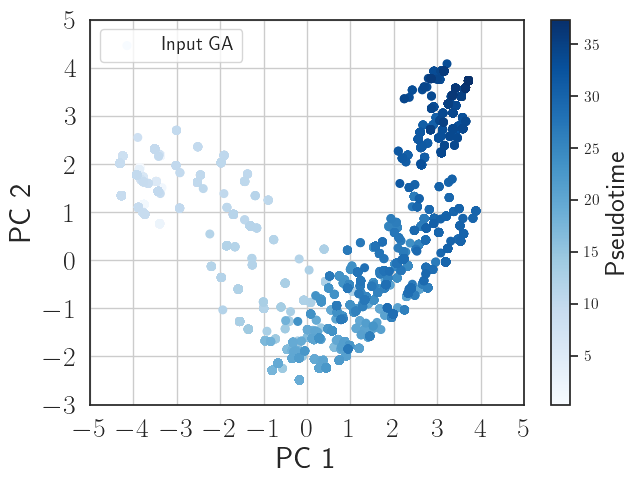

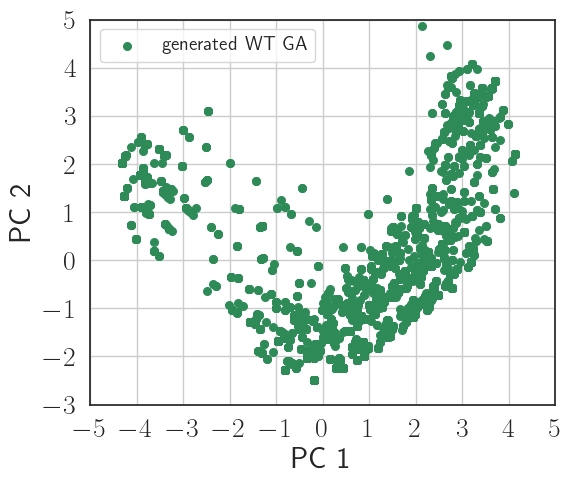

In [40]:
pca_input = PCA(n_components=2)
pca_input.fit(spins_df_lN_mb_pst.T)
input_spins_transformed = pca_input.transform(spins_df_lN_mb_pst.T)
new_spins_transformed = pca_input.transform(spins_new_lN[:,:,6].T)
input_spins_transformed[:,0] = -input_spins_transformed[:,0]
new_spins_transformed[:,0] = -new_spins_transformed[:,0]
principalDf_input = pd.DataFrame(data=input_spins_transformed, columns=['PC1', 'PC2'])
principalDf_new = pd.DataFrame(data=new_spins_transformed, columns=['PC1', 'PC2'])


# Plotting
plt.figure(figsize=(7,5))
font = {'family': 'Avenir', 'size': 22}
accent_palette = plt.cm.Accent
colors = ["darkgray", "royalblue", "indianred"]
colors = accent_palette([1, 2, 3])

# Mappatura dei colori per i dataset esistenti
scatter_pca1 = plt.scatter(principalDf_input['PC1'], principalDf_input['PC2'], label='Input GA', c=PST_MB_val.iloc[:,1], cmap='Blues', s=30, marker='o', alpha=1.0)
cbar = plt.colorbar()
cbar.set_label('Pseudotime', size=20) # Imposta la dimensione del font dell'etichetta della colorbar

# Impostazioni del grafico
plt.legend(prop={'size': 14, 'family': 'Avenir'}, loc='upper center')
plt.xlabel('PC 1', fontdict=font)
plt.ylabel('PC 2', fontdict=font)
plt.xticks(fontsize=20, fontname='Avenir')
plt.yticks(fontsize=20, fontname='Avenir')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.grid(True)
plt.xlim([-5,5])
plt.ylim([-3,5])
plt.legend(loc='upper left', fontsize=14)
plt.show()

# Plotting
plt.figure(figsize=(6,5))
font = {'family': 'Avenir', 'size': 22}

plt.scatter(principalDf_new['PC1'], principalDf_new['PC2'], label='generated WT GA',  color="seagreen" , s=30, marker='o', alpha=1)

plt.legend(prop={'size': 13, 'family': 'Avenir'}, loc='upper center')
plt.xlabel('PC 1', fontdict=font)
plt.ylabel('PC 2', fontdict=font)
plt.xticks(fontsize=20, fontname='Avenir')
plt.yticks(fontsize=20, fontname='Avenir')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.grid(True)
plt.xlim([-5,5])
plt.ylim([-3,5])
plt.legend(loc='upper left', fontsize=14)
plt.show()

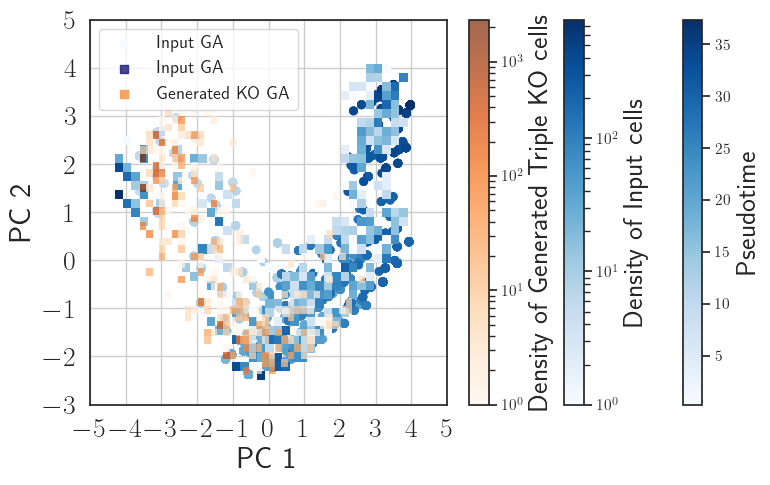

In [54]:
import matplotlib.colors as colors

spins_df_lN_mb_pst_reduced = np.delete(spins_df_lN_mb_pst, KO_gene_idk_T, axis=0)
pca_reduced = PCA(n_components=2)
pca_reduced.fit(spins_df_lN_mb_pst_reduced.T)

KO_T_spins_transformed = pca_reduced.transform(KO_T_spins[:,:,4].T)
WT_input_reduced_transformed = pca_reduced.transform(spins_df_lN_mb_pst_reduced.T)
KO_T_pca_df = pd.DataFrame(data=KO_T_spins_transformed, columns=['PC1', 'PC2'])
WT_input_reduced_df = pd.DataFrame(data=WT_input_reduced_transformed, columns=['PC1', 'PC2'])
plt.figure(figsize=(9, 5))

# pcm_input = plt.hist2d(WT_input_reduced_df['PC1'], WT_input_reduced_df['PC2'], bins=35, cmap='Purples', norm=colors.LogNorm(), alpha=1)
scatter_pca1 = plt.scatter(WT_input_reduced_df['PC1'], WT_input_reduced_df['PC2'], label='Input GA', c=PST_MB_val.iloc[:,1], cmap='Blues', s=30, marker='o', alpha=1.0)
cbar = plt.colorbar()
cbar.set_label('Pseudotime', size=20) # Imposta la dimensione del font dell'etichetta della colorbar

pcm_input = plt.hist2d(principalDf_input['PC1'], principalDf_input['PC2'], bins=35, cmap='Blues', norm=colors.LogNorm(), alpha=1)
pcm_ko_generated = plt.hist2d(KO_T_pca_df['PC1'], KO_T_pca_df['PC2'], bins=35, cmap='Oranges', norm=colors.LogNorm(), alpha=0.7)
cb_input = plt.colorbar(pcm_input[3])  # Mostra la barra dei colori
cb_input.set_label('Density of Input cells', fontsize=20)
cb_generated = plt.colorbar(pcm_ko_generated[3])  # Mostra la barra dei colori
cb_generated.set_label('Density of Generated Triple KO cells', fontsize=20)

# cb_generated.set_label('density', fontsize=20)
plt.scatter([], [], label='Input GA',  color="midnightblue" , s=30, marker='s', alpha=.8)
plt.scatter([], [], label='Generated KO GA',  color="sandybrown" , s=30, marker='s', alpha=.99)

# Impostazioni del grafico
plt.legend(prop={'size': 13, 'family': 'Avenir'}, loc='upper left')
plt.xlabel('PC 1', fontdict=font)
plt.ylabel('PC 2', fontdict=font)
plt.xticks(fontsize=20, fontname='Avenir')
plt.yticks(fontsize=20, fontname='Avenir')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.grid(True)
plt.xlim([-5,5])
plt.ylim([-3,5])

# Mostra il grafico
plt.savefig(figs_path+'/PCA_IGNITE_input_KO_GA.svg', format='svg', transparent=True, bbox_inches='tight')
plt.show()
